# Lab Six: CNNs

Team: Miro Ronac, Kirk Watson, Brandon Vincitore

Dataset Source: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [1]:
import os

import numpy as np

from PIL import Image
from numpy import asarray
from os import listdir
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## 1. Preparation

Load in images for dataset similar to Lab 2.

In [2]:
#file paths were chosen to have reasonably sized dataset
normal_dir = "chest_xray/train/NORMAL/"
pneumonia_dir = "chest_xray/test/PNEUMONIA/"

data = []
classes = []
h, w = 100, 100

#load normal images
normal_count=0
for images in os.listdir(normal_dir):
    #create image, resize to 100x100
    image = Image.open(normal_dir + images)
    image = image.resize((h,w))
    #convert image to numpy array and flatten
    data_i = asarray(image)
    #feature_i = data_i.flatten()
    #add image to list of images
    data.append(data_i)
    #store as false (not pneumonia)
    classes.append(0)
    normal_count+=1
    
#load pneumonia images
pneumonia_count=0
for images in os.listdir(pneumonia_dir):
    #create image, resize to 100x100
    image = Image.open(pneumonia_dir + images)
    image = image.resize((h,w))
    #convert image to numpy array and flatten
    data_i = asarray(image)
    #feature_i = data_i.flatten()
    #add image to list of images
    data.append(data_i)
    #store as true (pneumonia)
    classes.append(1)
    pneumonia_count+=1
    
data = np.asarray(data)
#normalize pixel data
data = data/255.0-0.5
data = np.expand_dims(data, axis=-1)

print(data.shape)
print(data.shape[0], 'total images')
print('Number of files:', len(classes))
print('Number of normal images:', normal_count, ', Number of pneumonia images:',pneumonia_count)

(1731, 100, 100, 1)
1731 total images
Number of files: 1731
Number of normal images: 1341 , Number of pneumonia images: 390


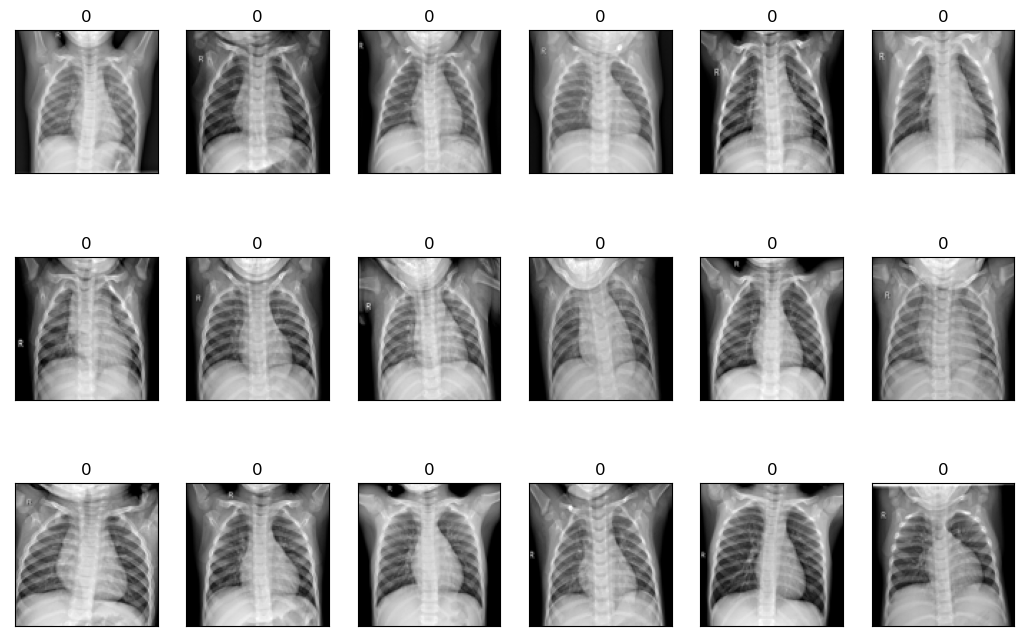

In [3]:
# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].squeeze(), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(data, classes, 100, 100)

### Evaluation metric

We chose to use the F1-score metric to account for the false negatives (recall) and false positives (precision) when evaulating our unbalanced unbalanced dataset. In the world of medicine and diagnostics, both false negatives and false positives are extremely important when evaluating a patient. We don't want to wrongly diagnose a patient with pneumonia, and we wouldn't want to wrongly diagnose a patient's lungs as healthy. With the F1-score, we have a better metric to minimize both false ocurrences. Additionally, our dataset is unbalanced in favor of normal lung images. The F1-score suits unbalanced datasets because it is calculated as a harmonic mean of precision and recall.

In [4]:
import tensorflow as tf
from tensorflow.keras import backend as K

# F1-score is no longer supported in keras so we must make a F1-score function
# From https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d

def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

### Divide data into training and testing

To divide our data into training and testing, we will use Stratified K-fold cross validation. We chose this method because we need to account for the imbalance of normal images and pneumonia images. A stratified split will create folds with balanced occurences of normal and pneumonia images. Using a K-fold split is beneficial for our small dataset because it will better assist our model with generalization. A K-fold split will help reduce variance and allow the model to fit with each fold.

In [5]:
from sklearn.model_selection import StratifiedKFold

X = data
y = np.asarray(classes)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

## 2. Modeling

### Data Expansion

For data augmentation, we are using the keras ImageDataGenerator. We chose this method as a preprocessing technique to shift image heights and widths as well as rotate images. Shifting images can possibly remove unwanted effects of non-uniform image shapes before processing. Including a small rotational adjustment can resemble x-ray images that were not positioned the same as other images but still share a similar orientation. We did not flip images because our dataset images all have similar orientations such as heart position and body structure.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05)

datagen.fit(X)

### Model 1

## 3. Exceptional Work